# Report on HW4: BiLSTM for NER

## Task 1: Simple Bidirectional LSTM model

### Word Vocabulary
I built a function that generates a vocabulary dictionary which maps each word/tag to corresbonding index. For the word vocab, there is also a threshold. For words with frequency below this threshold, they are counted as < unk >.

Using this, I generated word2id and tag2id, as well as their reverse id2word and id2tag which maps index to original word/tag.

Specifically, I found that adding extra embedding space for not only unknown words but also Capitalized unknown words helps boost the F1 from 77 to 83.

### Train and Eval Functions
On the foundation of the training function used in my previous homework, I added a Step Learning Rate Scheduler. This makes the training process of SGD much more flexible and controllable, and ofc less frustrating.

### Dataset
For my self-defined dataset object, it takes the sentences and tag list as input as well as word and tag mapping dictionaries mentioned above. The dataset will map each token to their index, including unknowns and its variations. Then, it transform each sentence vector to tensor, but not yet stacked.

Padding and stacking are done in my self-defined collate function, which padds a whole batch of sentence tensors to the length of the longest in the local batch, instead of the longest sentence in the whole corpus.

### Model Structure
For my simple BiLSTM model, there are 4 layers: Embedding layer, Bidirectional LSTM layer as the encoder, Linear layer, and ELU layer. On both sides of the linear layer, there is a dropout layer.

The Embedding layer has the size of the number of words x 100, and uniformly initializes from $[-\frac{1}{\sqrt(d)},\frac{1}{\sqrt(d)}]$.

After the embedding layer, the input sequence first undergoes the pack_padded_sequence into a packed tensor with no paddings, then go into the encoder. Then, the output undergoes the pad_packed_sequence to reverse back to the padded condition. This procedure greatly boosts the model's efficiency.

### Training
Trained SGD with 100 epochs, lr start with 0.3, step_size=20, gamma=0.8. The learning rates starts high because SGD is very sensitive with learning rate, and at the beginning finding the right direction requires a large learning rate.

### Result
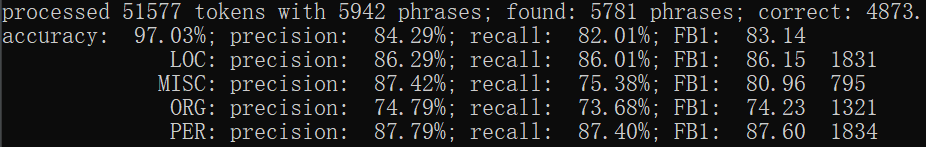

## Task 2: Implementing GLoVe Embeddings

### Constructing Embedding Matrix
There are two objects that needs to be generated: the Embedding matrix and a corresponding word2id dictionary. To deal with the fact that GloVe's insensitivity to capitalization, I added 2 more duplicates for each word: one for capitalization, one for FULL capitalization. This is because not only there are capitalized words, but there are also lots of FULL capitalized words. According to Piazza, I also added an extra dimension to specify if the word is lower, upper or capitalized. But since the dimension is not freezed, I doubt its usefulness.

### Model Structure
For the model, I just load the weights of the embedding layer from my generated embedding matrix.

### Training
Trained SGD with 50 epochs, lr start with 0.8, step_size=12, gamma=0.9. Again, SGD starts high on the learning rate. Comparing with simple BiLSTM training, a lot fewer number of epochs is due to 2 reasons I believe: 
1. GLoVe provides a already trained embedding layer, which is a much better initialization then uniform randomization. This greatly reduces the number of steps for optimization the embeddings.
2. GLoVe has a huge vocab, which greatly helps to improve the efficiency and the performance of BLSTM.

### Result
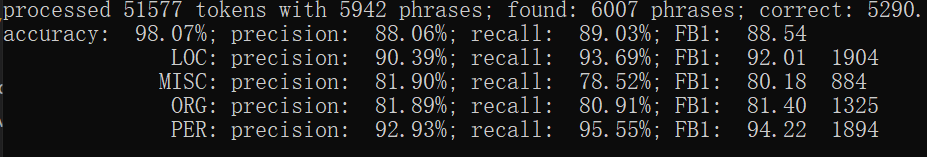

## Bonus Task: BiLSTM with Character-level CNN

To learn character level information, there needs to be a character vocabulary that transforms all characters to corresponding index. A simple way to explain how the character-level CNN works with BiLSTM is that I just create a seperate CNN model, and its resulted character-level embedding for each word is then concatenated to the glove embedding in the above task. 

In detail, the CNN model is composed of a character embedding layer, a 1D CNN layer with kernel size 3, a 1D CNN layer with kernel size 2, and dropout layers. I also froze the glove embedding in the BiLSTM model, while adding 50 more dimensions for training. Ultimately, the total concatenated embedding size is 101+30+50 = 181. The result has improved for about 2%, which is less than expected.

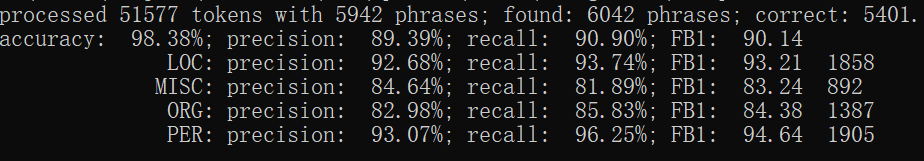

# Code

## Import

In [1]:
import pandas as pd
import numpy as np
import re
import csv
import re
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from transformers import DataCollatorWithPadding
from torch.optim.lr_scheduler import StepLR

c:\Users\Ruijier\Anaconda3\envs\DataSci\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [2]:
def read_data(dir):
  file_dir = dir
  sentence_list = []
  tag_list = []
  with open(file_dir) as file:
    sentence = []
    tags = []
    for line in file.readlines():
      line = line.strip().split()
      if len(line) == 0:
        sentence_list.append(sentence)
        tag_list.append(tags)
        sentence = []
        tags = []
        continue
      if dir.endswith('test'):
        tag = ''
      else:
        tag = line[-1]
      index, word = line[:2]
      sentence.append(word)
      tags.append(tag)
  return sentence_list, tag_list


In [3]:
from collections import Counter
def create_dic(corpus, thres=5):
  counter = Counter([word for sent in corpus for word in sent])
  if not thres:
    result = {item[0]:id+1 for id,item in enumerate(counter.most_common())}
  else:
    result = {item[0]:id+1 for id,item in enumerate(counter.most_common()) if item[1]>thres}
  result['< pad >'] = 0
  return result

In [4]:
train_sentences, train_tags = read_data(f"data/train")
dev_sentences, dev_tags = read_data(f"data/dev")
test_sentences, _ = read_data(f"data/test")

word2id = create_dic(train_sentences, thres=2)
word2id['< unk >'] = len(word2id)
word2id['< up_unk >'] = len(word2id)
word2id['< cap_unk >'] = len(word2id)
id2word = {v:k for k,v in word2id.items()}

tag2id = create_dic(train_tags, thres=None)
id2tag = {v:k for k,v in tag2id.items()}

vocab_size = len(word2id)
tag_count = len(tag2id)

## Train & Eval

In [36]:
def output_result(sentence_list, tag_list, predction_list, output_dir, test=False):
  print(f"Writing result to {output_dir}..")
  with open(output_dir,"w") as file:
    if test:
      for sentence,preds in zip(sentence_list, predction_list):
        index = 1
        for w,p in zip(sentence,preds):
          file.write(f"{index} {w} {p}\n")
          index += 1
    else:
      for sentence,tags,preds in zip(sentence_list, tag_list, predction_list):
        index = 1
        for w,t,p in zip(sentence,tags,preds):
          file.write(f"{index} {w} {t} {p}\n")
          index += 1
    print("Complete")

In [15]:
def eval(model, loader, criterion, device):
  test_loss = 0.0
  model.eval()
  for data, label, lengths in loader:
    data = data.to(device)
    label = label.to(device)
    pred = model(data, lengths)
    #label = F.one_hot(label, num_classes=10).float()
    loss = criterion(torch.permute(pred,(0,2,1)), label)
    test_loss += loss.item()*data.size(0)
    
  test_loss = test_loss/len(loader.dataset)
  return test_loss

def train(model, train_loader, val_loader, epoch_num, device, lr=0.5, step_size=5, gamma=1, momentum=0.8):
  criterion = nn.CrossEntropyLoss()
  weight_decay = 1e-4
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
  #optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma, verbose=False)
  best_val_loss = np.inf
  for epoch in range(epoch_num):
    train_loss = 0.0
    model.train()
    for data, label, lengths in train_loader:
      data = data.to(device)
      label = label.to(device)
      #label = F.one_hot(label, num_classes=10).float()
      optimizer.zero_grad()
      pred = model(data, lengths)
      #print(pred.shape,label.shape)
      loss = criterion(torch.permute(pred,(0,2,1)), label)
      loss.backward()

      #indices = torch.LongTensor([-1])
      #model.emb_layer.weight.grad[indices] = 0
      
      optimizer.step()
      train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    val_loss = eval(model, val_loader, criterion, device)
    #if epoch_num>10 and (epoch+1)%10 == 0:
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss}")
    print(f"[Epoch {epoch+1}] Val Loss: {val_loss}")
    if val_loss<best_val_loss:
      best_val_loss = val_loss
      torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'best_model.pth')
    scheduler.step()
  #print(best_val_loss)
  checkpoint = torch.load('best_model.pth')
  model.load_state_dict(checkpoint['model_state_dict'])

## BiLSTM

### Dataset

In [7]:
class NER(Dataset):
    
    def __init__(self, sentence_list, tag_list, word2id, tag2id, transform=None):
        self.sentence_list = sentence_list
        self.tag_list = tag_list
        self.transform = transform
        self.word2id = word2id
        self.tag2id = tag2id
        #self.total_tag_count = len(tag2id)
        self.lengths = [len(sent) for sent in self.sentence_list]
        self.X = [torch.tensor([self.mapword2id(word) for word in sentence]) for sentence in self.sentence_list]
        self.y = [torch.tensor([self.tag2id.get(tag,0) for tag in tags]) for tags in self.tag_list]

    def mapword2id(self,word):
        try:
            return self.word2id[word]
        except KeyError:
            if word.isupper():
                return self.word2id['< up_unk >']
            elif word[0].isupper():
                return self.word2id['< cap_unk >']
            else:
                return self.word2id['< unk >']
        
    def __len__(self):
        return len(self.sentence_list)
    
    def __getitem__(self, index):
        emb = self.X[index] #.astype('float32').reshape(())
        unpad_len = self.lengths[index]
        label = self.y[index] #F.one_hot(label, num_classes=self.tag_len) #.float()
        
        if self.transform is not None:
            emb = self.transform(emb)
            
        return emb, label, unpad_len

In [8]:
def collate_fn_padd(batch):
  data,label,lengths = zip(*batch)
  padded_data = pad_sequence(data, batch_first=True)
  padded_label = pad_sequence(label, batch_first=True)
  #print(padded_data.shape, padded_label.shape)
  return padded_data, padded_label, torch.tensor(lengths)

In [9]:
batch_size = 64
train_ds = NER(train_sentences, train_tags, word2id, tag2id)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
    shuffle=True, collate_fn=collate_fn_padd)
val_ds = NER(dev_sentences, dev_tags, word2id, tag2id)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
    shuffle=False, collate_fn=collate_fn_padd)
test_ds = NER(test_sentences, [[0 for word in sent] for sent in test_sentences], word2id, tag2id)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
    shuffle=False, collate_fn=collate_fn_padd)

### Model

In [10]:
class BiLSTM(nn.Module):
    def __init__(self, device, vocab_size, hidden_size, output_size, emb_size = 100, n_layers=1, dropout=0.33, emb=None):
        super(BiLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb_layer = nn.Embedding(vocab_size, emb_size, padding_idx=0, device=device)
        self.emb_layer.weight.data.uniform_(-np.sqrt(1/emb_size), np.sqrt(1/emb_size))
        self.encoder_layer = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout, bidirectional=True, batch_first=True, device=device)
        self.linear_layer1 = nn.Linear(hidden_size*2, 128, device=device)
        self.dropout = nn.Dropout(dropout)
        self.linear_layer2 = nn.Linear(128, output_size, device=device)
        self.elu = nn.ELU()

    def forward(self, x, x_lengths):
        x = self.emb_layer(x)
        #print(x.shape)
        x = pack_padded_sequence(x, lengths=x_lengths, batch_first=True, enforce_sorted=False)
        x,_ = self.encoder_layer(x)
        #print(x.data.shape)
        x,_ = pad_packed_sequence(x, batch_first=True)
        #print(x.shape)
        x = self.dropout(x)
        x = self.linear_layer1(x)
        x = self.dropout(x)
        x = self.elu(x)
        x = self.linear_layer2(x)
        x = self.dropout(x)
        return x


In [11]:
device = 'cuda:0'
model = BiLSTM(device, vocab_size, 256, tag_count).to(device)

c:\Users\Ruijier\Anaconda3\envs\DataSci\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.33 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
train(model, train_loader, val_loader, 50, device, lr=0.5, step_size=5, gamma=0.8)

[Epoch 1] Train Loss: 0.6886963956938015
[Epoch 1] Val Loss: 0.25937818406206187
[Epoch 2] Train Loss: 0.6140043520329235
[Epoch 2] Val Loss: 0.21402304450756887
[Epoch 3] Train Loss: 0.5655946668088794
[Epoch 3] Val Loss: 0.15539676887648446
[Epoch 4] Train Loss: 0.5394739222497913
[Epoch 4] Val Loss: 0.14350656648347904
[Epoch 5] Train Loss: 0.5269281734663575
[Epoch 5] Val Loss: 0.13197942400219465
[Epoch 6] Train Loss: 0.5208621700042624
[Epoch 6] Val Loss: 0.1277629439362888
[Epoch 7] Train Loss: 0.5164638011792497
[Epoch 7] Val Loss: 0.11176300326639095
[Epoch 8] Train Loss: 0.5120062452999371
[Epoch 8] Val Loss: 0.10443478694123795
[Epoch 9] Train Loss: 0.5085595661070037
[Epoch 9] Val Loss: 0.10007111168699002
[Epoch 10] Train Loss: 0.505216880262606
[Epoch 10] Val Loss: 0.10517291971314349
[Epoch 11] Train Loss: 0.5021530379921926
[Epoch 11] Val Loss: 0.09607522511723066
[Epoch 12] Train Loss: 0.501132475984569
[Epoch 12] Val Loss: 0.08660261695519154
[Epoch 13] Train Loss: 0.

In [20]:
PATH = "models/blstm1.pt"

In [21]:
torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load(PATH))

### Evaluation

In [17]:
pred_list = []
model.eval()
with torch.no_grad():
  predictions = []
  for data,labels,lengths in val_loader:
    data = data.to(device)
    labels = labels.to(device)
    pred = model(data,lengths)
    pred_list += [[id2tag[i] for i in p[:len]] for p,len in zip(pred.argmax(-1).tolist(),lengths.tolist())]

In [19]:
output_result(dev_sentences, dev_tags, pred_list, "result/dev1.out")

## GLoVe

### Embedding Creation

In [6]:
glove_vocab = {} # word2id in glove 
glove_emb = [] # array of embeddings, with index i corresponding to the word x glove_vocab[x] = i
count = 4
with open('glove.6B.100d.txt', encoding='utf-8') as file:
  for line in file.readlines():
    line = line.strip().split()
    word, value = line[0], np.array(line[1:]+[0]).astype(float) # add another dimension for capitalization
    glove_vocab[word] = count
    glove_emb.append(value)
    count += 1
    # Add capitalized word
    cap_word = word.capitalize()
    if cap_word != word and cap_word not in glove_vocab.keys():
      glove_vocab[cap_word] = count
      cap_value = value.copy()
      cap_value[-1] = 1
      glove_emb.append(cap_value)
      count += 1
    # Add upper word
    upper_word = word.upper()
    if upper_word != word and upper_word not in glove_vocab.keys():
      glove_vocab[upper_word] = count
      upper_value = value.copy()
      upper_value[-1] = 2
      glove_emb.append(upper_value)
      count += 1
glove_emb = np.array(glove_emb)

In [7]:
assert len(glove_vocab)==len(glove_emb)

In [8]:
# Add pad and unk emb
pad_emb = np.zeros((1, glove_emb.shape[1])) # zero for padding
unk_emb = np.mean(glove_emb, axis=0) # mean for unknown
unk_emb[-1] = 0
unk_cap_emb = unk_emb.copy()
unk_cap_emb[-1] = 1
unk_up_emb = unk_emb.copy()
unk_up_emb[-1] = 2
glove_vocab["< pad >"] = 0
glove_vocab["< unk >"] = 1
glove_vocab["< cap_unk >"] = 2
glove_vocab["< up_unk >"] = 3
glove_emb = np.vstack((pad_emb,unk_emb, unk_cap_emb,unk_up_emb,glove_emb))

### Dataset

In [22]:
class GLoVe_NER(Dataset):
    
    def __init__(self, sentence_list, tag_list, word2id, tag2id, transform=None):
      self.sentence_list = sentence_list
      self.tag_list = tag_list
      self.transform = transform
      self.word2id = word2id
      self.tag2id = tag2id
      #self.total_tag_count = len(tag2id)
      self.lengths = [len(sent) for sent in self.sentence_list]
      self.X = [torch.tensor([self.mapword2id(word) for word in sentence]) for sentence in self.sentence_list]
      self.y = [torch.tensor([self.tag2id.get(tag,0) for tag in tags]) for tags in self.tag_list]

    def mapword2id(self,word):
      try:
        return self.word2id[word]
      except KeyError:
        if word.isupper():
          return self.word2id['< up_unk >']
        elif word[0].isupper():
          return self.word2id['< cap_unk >']
        else:
          return self.word2id['< unk >']
    
    def __len__(self):
      return len(self.sentence_list)
    
    def __getitem__(self, index):
      emb = self.X[index] #.astype('float32').reshape(())
      unpad_len = self.lengths[index]
      label = self.y[index] #F.one_hot(label, num_classes=self.tag_len) #.float()
      
      if self.transform is not None:
          emb = self.transform(emb)
          
      return emb, label, unpad_len

In [27]:
batch_size = 32
train_ds = GLoVe_NER(train_sentences, train_tags, glove_vocab, tag2id)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
    shuffle=True, collate_fn=collate_fn_padd)
val_ds = GLoVe_NER(dev_sentences, dev_tags, glove_vocab, tag2id)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
    shuffle=False, collate_fn=collate_fn_padd)
test_ds = GLoVe_NER(test_sentences, [[0 for word in sent] for sent in test_sentences], glove_vocab, tag2id)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
    shuffle=False, collate_fn=collate_fn_padd)

### Model

In [28]:
class BiLSTM_GLoVe(nn.Module):
    def __init__(self, device, emb, vocab_size, hidden_size, output_size, emb_size = 100, n_layers=1, dropout=0.33):
        super(BiLSTM_GLoVe, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.emb_layer = nn.Embedding(vocab_size, emb_size, padding_idx=0, device=device)
        self.emb_layer.load_state_dict({'weight': torch.from_numpy(emb).float()})
        self.emb_layer.weight.requires_grad = False
        self.encoder_layer = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout, bidirectional=True, batch_first=True, device=device)
        self.linear_layer1 = nn.Linear(hidden_size*2, 128, device=device)
        self.dropout = nn.Dropout(dropout)
        self.linear_layer2 = nn.Linear(128, output_size, device=device)
        self.elu = nn.ELU()

    def forward(self, x, x_lengths):
        '''
        idx_sort = torch.argsort(-x_lengths)
        idx_unsort = torch.argsort(idx_sort)
        x = x[idx_sort]
        x_lengths = x_lengths[idx_sort]
        '''
        x = self.emb_layer(x)
        #print(x.shape)
        x = pack_padded_sequence(x, lengths=x_lengths, batch_first=True, enforce_sorted=False)
        x,_ = self.encoder_layer(x)
        #print(x.data.shape)
        x,_ = pad_packed_sequence(x, batch_first=True)
        #print(x.shape)
        x = self.dropout(x)
        x = self.linear_layer1(x)
        x = self.dropout(x)
        x = self.elu(x)
        x = self.linear_layer2(x)
        x = self.dropout(x)
        return x



### Train

In [29]:
device = 'cuda:0'
model = BiLSTM_GLoVe(device, glove_emb, glove_emb.shape[0], 256, tag_count, emb_size=glove_emb.shape[1]).to(device)

In [31]:
train(model, train_loader, val_loader, 50, device, lr=0.6, step_size=8, gamma=0.8)

[Epoch 1] Train Loss: 0.5474158843893975
[Epoch 1] Val Loss: 0.07867985959090884
[Epoch 2] Train Loss: 0.4817019516852483
[Epoch 2] Val Loss: 0.051499181848777324
[Epoch 3] Train Loss: 0.4727221729161026
[Epoch 3] Val Loss: 0.04516834384542695
[Epoch 4] Train Loss: 0.4697024869486087
[Epoch 4] Val Loss: 0.03979266196983889
[Epoch 5] Train Loss: 0.4691021300342203
[Epoch 5] Val Loss: 0.036458474912104154
[Epoch 6] Train Loss: 0.4652352772685916
[Epoch 6] Val Loss: 0.032706719779370494
[Epoch 7] Train Loss: 0.4632299053610111
[Epoch 7] Val Loss: 0.03441737758702616
[Epoch 8] Train Loss: 0.46143718978424153
[Epoch 8] Val Loss: 0.032578494653514284
[Epoch 9] Train Loss: 0.4617381168433189
[Epoch 9] Val Loss: 0.03258105388816989
[Epoch 10] Train Loss: 0.46069669536177316
[Epoch 10] Val Loss: 0.03832402697308755
[Epoch 11] Train Loss: 0.45873089651948185
[Epoch 11] Val Loss: 0.02977140559069006
[Epoch 12] Train Loss: 0.45841087893110943
[Epoch 12] Val Loss: 0.030394978041278164
[Epoch 13] Tr

In [33]:
PATH = "models/blstm2.pt"

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Evaluation

In [34]:
id2word = {v:k for k,v in glove_vocab.items()}

In [35]:
pred_list = []
model.eval()
with torch.no_grad():
  predictions = []
  for data,labels,lengths in val_loader:
    data = data.to(device)
    labels = labels.to(device)
    pred = model(data,lengths)
    #print()
    pred_list += [[id2tag[i] for i in p[:len]] for p,len in zip(pred.argmax(-1).tolist(),lengths.tolist())]

In [37]:
output_result(dev_sentences, dev_tags, pred_list, "result/dev2.out")

## BiLSTM CNN

In [9]:
char2id = create_dic([char for sent in train_sentences for word in sent for char in word])
char2id["< unk >"] = len(char2id)
id2char = {v:k for k,v in char2id.items()}

In [10]:
class NER_Char(Dataset):
    
    def __init__(self, sentence_list, tag_list, word2id, tag2id, char2id, transform=None):
        self.sentence_list = sentence_list
        self.tag_list = tag_list
        self.transform = transform
        self.word2id = word2id
        self.tag2id = tag2id
        self.char2id = char2id
        #self.total_tag_count = len(tag2id)
        self.lengths = [len(sent) for sent in self.sentence_list]
        self.X = [torch.tensor([self.mapword2id(word) for word in sentence]) for sentence in self.sentence_list]
        self.y = [torch.tensor([self.tag2id.get(tag,0) for tag in tags]) for tags in self.tag_list]
        self.z = [torch.tensor([self.my_padding([self.char2id.get(char,self.char2id["< unk >"]) for char in word]) for word in sentence]) for sentence in self.sentence_list]

    def mapword2id(self,word):
        try:
            return self.word2id[word]
        except KeyError:
            if word.isupper():
                return self.word2id['< up_unk >']
            elif word[0].isupper():
                return self.word2id['< cap_unk >']
            else:
                return self.word2id['< unk >']

    def my_padding(self,x,max_length=70):
        return x+[0 for i in range(max_length-len(x))]

    def __len__(self):
        return len(self.sentence_list)
    
    def __getitem__(self, index):
        emb = self.X[index] #.astype('float32').reshape(())
        unpad_len = self.lengths[index]
        label = self.y[index] #F.one_hot(label, num_classes=self.tag_len) #.float()
        chars = self.z[index]
        
        if self.transform is not None:
            emb = self.transform(emb)
            
        return emb, label, chars, unpad_len

In [11]:
def collate_fn_char(batch):
  data,label,chars,lengths = zip(*batch)
  max_length = max(lengths)
  padded_data = pad_sequence(data, batch_first=True)
  padded_label = pad_sequence(label, batch_first=True)
  padded_chars = pad_sequence(chars, batch_first=True)
  #print(padded_chars.shape)
  return padded_data, padded_label, padded_chars, torch.tensor(lengths), 

In [12]:
batch_size = 32
train_ds = NER_Char(train_sentences, train_tags, glove_vocab, tag2id, char2id)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
    shuffle=True, collate_fn=collate_fn_char)
val_ds = NER_Char(dev_sentences, dev_tags, glove_vocab, tag2id, char2id)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
    shuffle=False, collate_fn=collate_fn_char)
test_ds = NER_Char(test_sentences, [[0 for word in sent] for sent in test_sentences], glove_vocab, tag2id, char2id)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
    shuffle=False, collate_fn=collate_fn_char)

In [17]:
def new_eval(model, loader, criterion, device):
  test_loss = 0.0
  model.eval()
  for data, label, chars, lengths in loader:
    data = data.to(device)
    label = label.to(device)
    chars = chars.to(device)
    pred = model(data, chars, lengths)
    #label = F.one_hot(label, num_classes=10).float()
    loss = criterion(torch.permute(pred,(0,2,1)), label)
    test_loss += loss.item()*data.size(1)
    
  test_loss = test_loss/len(loader.dataset)
  return test_loss

def new_train(model, train_loader, val_loader, epoch_num, device, lr=0.5, step_size=5, gamma=1, momentum=0.8):
  criterion = nn.CrossEntropyLoss()
  weight_decay = 1e-4
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
  #optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma, verbose=False)
  best_val_loss = np.inf
  for epoch in range(epoch_num):
    train_loss = 0.0
    model.train()
    for data, label, chars, lengths in train_loader:
      data = data.to(device)
      label = label.to(device)
      chars = chars.to(device)
      #label = F.one_hot(label, num_classes=10).float()
      optimizer.zero_grad()
      pred = model(data, chars, lengths)
      #print(pred.shape)
      loss = criterion(torch.permute(pred,(0,2,1)), label)
      loss.backward()

      #indices = torch.LongTensor([-1])
      #model.emb_layer.weight.grad[indices] = 0
      
      optimizer.step()
      train_loss += loss.item()*data.size(1)
    train_loss = train_loss/len(train_loader.dataset)
    val_loss = new_eval(model, val_loader, criterion, device)
    #if epoch_num>10 and (epoch+1)%10 == 0:
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss}")
    print(f"[Epoch {epoch+1}] Val Loss: {val_loss}")
    if val_loss<best_val_loss:
      best_val_loss = val_loss
      torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'best_model.pth')
    scheduler.step()
  #print(best_val_loss)
  checkpoint = torch.load('best_model.pth')
  model.load_state_dict(checkpoint['model_state_dict'])

In [28]:
class CharCNN(nn.Module):
    def __init__(self, num_chars, embedding_dim, num_filters):
        super(CharCNN, self).__init__()
        self.embedding = nn.Embedding(num_chars, embedding_dim)
        self.embedding.weight.data.uniform_(-np.sqrt(1/embedding_dim), np.sqrt(1/embedding_dim))
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=3, padding=1)
        #self.conv3 = nn.Conv1d(num_filters, num_filters, kernel_size=5, padding=1)
        #self.linear = nn.Sequential(nn.Linear(num_filters, n_fc_neurons), nn.Dropout(0.5))
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # x: (batch_size, seq_len, word_len)
        x = self.embedding(x)
        x = self.dropout(x)
        # x: (batch_size, seq_len, word_len, embedding_dim)
        x = x.transpose(2, 3).contiguous()
        # x: (batch_size, seq_len, embedding_dim, word_len)
        batch_size, seq_len, embedding_dim, word_len = x.size()
        x = x.view(-1, embedding_dim, word_len)
        # x: (batch_size * seq_len, embedding_dim, word_len)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        # x: (batch_size * seq_len, num_filters, word_len)
        x = F.max_pool1d(x, kernel_size=x.size(-1)).squeeze(-1)
        # x: (batch_size * seq_len, num_filters)
        x = x.view(batch_size, seq_len, -1)
        # x: (batch_size, seq_len, num_filters)
        x = self.dropout(x)
        return x

In [29]:
class BiLSTM_CNN(nn.Module):
    def __init__(self, device, emb, char_size, hidden_size, output_size, emb_size = 100, n_layers=1, dropout=0.33):
        super(BiLSTM_CNN, self).__init__()
        self.vocab_size = emb.shape[0]
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        char_emb_size = 30
        train_emb_size = 50
        self.charcnn = CharCNN(char_size,char_emb_size,char_emb_size)
        self.emb_layer_glove = nn.Embedding(self.vocab_size, emb_size, padding_idx=0, device=device)
        self.emb_layer_glove.load_state_dict({'weight': torch.from_numpy(emb).float()})
        self.emb_layer_glove.weight.requires_grad = False
        self.emb_layer_train = nn.Embedding(self.vocab_size, train_emb_size, padding_idx=0, device=device)
        self.emb_layer_train.weight.data.uniform_(-np.sqrt(1/emb_size), np.sqrt(1/emb_size))
        self.encoder_layer = nn.LSTM(char_emb_size+emb_size+train_emb_size, hidden_size, n_layers, dropout=dropout, bidirectional=True, batch_first=True, device=device)
        self.linear_layer1 = nn.Linear(hidden_size*2, 128, device=device)
        self.dropout = nn.Dropout(dropout)
        self.linear_layer2 = nn.Linear(128, output_size, device=device)
        self.elu = nn.ELU()

    def forward(self, x, x_chars, x_lengths):
        char_x = self.charcnn(x_chars)
        glove_x = self.emb_layer_glove(x)
        train_x = self.emb_layer_train(x)
        x = torch.cat([char_x, glove_x, train_x], dim=-1)
        x = pack_padded_sequence(x, lengths=x_lengths, batch_first=True, enforce_sorted=False)
        x,_ = self.encoder_layer(x)
        x,_ = pad_packed_sequence(x, batch_first=True)
        x = self.dropout(x)
        x = self.linear_layer1(x)
        x = self.dropout(x)
        x = self.elu(x)
        x = self.linear_layer2(x)
        x = self.dropout(x)
        return x



In [32]:
device = 'cuda:0'
model = BiLSTM_CNN(device, glove_emb, len(char2id), 256, tag_count, emb_size=glove_emb.shape[1]).to(device)

In [33]:
new_train(model, train_loader, val_loader, 60, device, lr=0.7, step_size=5, gamma=0.7)

[Epoch 1] Train Loss: 0.7154733876484061
[Epoch 1] Val Loss: 0.07067804395786956
[Epoch 2] Train Loss: 0.6379325273047138
[Epoch 2] Val Loss: 0.051263772425057655
[Epoch 3] Train Loss: 0.6251540325773934
[Epoch 3] Val Loss: 0.04553402696062863
[Epoch 4] Train Loss: 0.6170024170081511
[Epoch 4] Val Loss: 0.041968230796846175
[Epoch 5] Train Loss: 0.619988497999423
[Epoch 5] Val Loss: 0.046590153714252194
[Epoch 6] Train Loss: 0.6143037146490565
[Epoch 6] Val Loss: 0.03888660127211034
[Epoch 7] Train Loss: 0.6153543090392349
[Epoch 7] Val Loss: 0.03712516222774047
[Epoch 8] Train Loss: 0.6111661048016147
[Epoch 8] Val Loss: 0.03816660484198271
[Epoch 9] Train Loss: 0.6121297496912016
[Epoch 9] Val Loss: 0.03630721062538718
[Epoch 10] Train Loss: 0.6096305993813055
[Epoch 10] Val Loss: 0.03884819475483703
[Epoch 11] Train Loss: 0.6057587058807778
[Epoch 11] Val Loss: 0.03602542064413375
[Epoch 12] Train Loss: 0.6042995478713782
[Epoch 12] Val Loss: 0.033528535423832606
[Epoch 13] Train Lo

In [19]:
id2word = {v:k for k,v in glove_vocab.items()}

In [39]:
pred_list = []
model.eval()
with torch.no_grad():
  predictions = []
  for data,labels,chars,lengths in test_loader:
    data = data.to(device)
    labels = labels.to(device)
    chars = chars.to(device)
    pred = model(data,chars,lengths)
    #print()
    pred_list += [[id2tag[i] for i in p[:len]] for p,len in zip(pred.argmax(-1).tolist(),lengths.tolist())]

In [38]:
output_result(dev_sentences, dev_tags, pred_list, "result/dev3.out")

Writing result to result/dev3.out..
Complete


In [40]:
output_result(test_sentences, None, pred_list, "result/test3.out", test=True)

Writing result to test3.out..
Complete


In [41]:
PATH = "models/blstm3.pt"

In [42]:
torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load(PATH))

In [19]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>